In [3]:
import gc
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from lightgbm import LGBMClassifier


warnings.filterwarnings('ignore')

In [14]:
df= pd.read_csv(Path("birlestirilmis_data.csv"), nrows = None)
pd.options.display.max_columns = df.shape[1]
df.head(24)


,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,FONDKAPREMONT_MODE_nan,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,HOUSETYPE_MODE_nan,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_nan,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_nan,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_nan,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,OCCUPATIO

In [ ]:
# dataframe i test ve train olarak bölüyoruz
train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

In [5]:
folds = KFold(n_splits=2, shuffle=True, random_state=1001)

In [6]:
# sonuçları depolamak için dataframe oluşturuyoruz
train_sonuc = np.zeros(train_df.shape[0])
test_sonuc = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]


In [7]:
print(train_df.shape)

(307507, 512)


####-------------------------------------

# #### LightGBM ####


In [8]:
# Iterate through each fold
for train_indices, valid_indices in folds.split(train_df[feats],train_df['TARGET']):
        
    # Training data for the fold
    train_features, train_labels = train_df[feats].iloc[train_indices], train_df['TARGET'].iloc[train_indices]
    # Validation data for the fold
    valid_features, valid_labels = train_df[feats].iloc[valid_indices], train_df['TARGET'].iloc[valid_indices]
        
    # Create the model
    model = LGBMClassifier(n_estimators=5000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
    
        
    # Train the model
    model.fit(train_features, train_labels, eval_metric = 'auc',
                eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                eval_names = ['valid', 'train'],
                early_stopping_rounds = 100, verbose = 200)
    
    train_sonuc[valid_indices] = model.predict_proba(valid_features, num_iteration=model.best_iteration_)[:, 1]
    test_sonuc += model.predict_proba(test_df[feats], num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = model.feature_importances_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    del model, train_features, train_labels, valid_features, valid_labels
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], train_sonuc))

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.849763	train's binary_logloss: 0.496411	valid's auc: 0.781213	valid's binary_logloss: 0.521839
Early stopping, best iteration is:
[219]	train's auc: 0.854958	train's binary_logloss: 0.490485	valid's auc: 0.781333	valid's binary_logloss: 0.51811
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.850495	train's binary_logloss: 0.494451	valid's auc: 0.779496	valid's binary_logloss: 0.524436
[400]	train's auc: 0.894581	train's binary_logloss: 0.44245	valid's auc: 0.77911	valid's binary_logloss: 0.490768
Early stopping, best iteration is:
[322]	train's auc: 0.879679	train's binary_logloss: 0.460776	valid's auc: 0.779856	valid's binary_logloss: 0.502547
Full AUC score 0.780474


In [9]:
test_df['TARGET'] = test_sonuc
test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index= False)

In [10]:
sonuc_DFDF = pd.read_csv(Path("submission.csv"))
sonuc_DFDF.head()

,SK_ID_CURR,TARGET
0,100001,0.288335
1,100005,0.574018
2,100013,0.163895
3,100028,0.234173
4,100038,0.667975


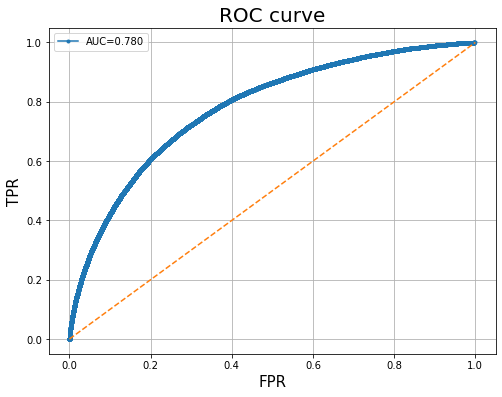

In [11]:
fpr, tpr, thresholds = roc_curve(train_df['TARGET'], train_sonuc)
auc = roc_auc_score(train_df['TARGET'],train_sonuc)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15, )
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()
